* Similar with ViscDiff.ipynb, this is to look at October.

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import (nc_tools,viz_tools,tidetools)
import seaborn as sns
import os
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

In [2]:
runs=['oct8_101e061e05','oct8_10reduceviscosity']
base='/data/jieliu/MEOPAR/river-treatment/'
sals={}; depths={}; Us={}; Vs={}
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
bathy=grid.variables['Bathymetry']
for run in runs:
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_T.nc'.format(run))
    f = nc.Dataset(path,'r');
    sals[run]=f.variables['vosaline']
    depths[run] = f.variables['deptht'] 
    T_lat = f.variables['nav_lat']
    T_lon = f.variables['nav_lon']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_U.nc'.format(run))
    f = nc.Dataset(path,'r');
    Us[run]=f.variables['vozocrtx']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_V.nc'.format(run))
    f = nc.Dataset(path,'r');
    Vs[run]=f.variables['vomecrty']

In [3]:
def quiver_salinity(t,dep,imin=240,imax=397,jmin=380,jmax=500,st=5,cmin= -4, cmax=4, dels = 0.4):
    "compare rivers and salinity at t, dep in box. st is quiver arrow interval"
    fig,axs = plt.subplots(1,3,figsize=(40,15))
    x=np.arange(imin,imax)
    y=np.arange(jmin,jmax)
    U={}; V={};u={};v={};uE={};vN={};
    for key, ax in zip(runs,axs[:-1]):
        #truncate U/V and unstagger
        U[key]= Us[key][t,dep,jmin-1:jmax,imin-1:imax]
        V[key] =Vs[key][t,dep,jmin-1:jmax,imin-1:imax]
        lon=T_lon[jmin:jmax,imin:imax]
        lat=T_lat[jmin:jmax,imin:imax]
        S=sals[key][t,dep,jmin:jmax,imin:imax]
        #masking
        U[key] = np.ma.masked_values(U[key],0)
        V[key] = np.ma.masked_values(V[key],0)
        #unstagger
        u[key],v[key] = viz_tools.unstagger(U[key],V[key])
        #rotate
        theta = np.pi*29/180
        uE[key] = u[key]*np.cos(theta) - v[key]*np.sin(theta)
        vN[key] = u[key]*np.sin(theta) +v[key]*np.cos(theta)
        #mesh
        mesh=ax.pcolormesh(lon,lat,S,cmap='spectral')
        viz_tools.plot_land_mask(ax,grid,coords='map',color='burlywood')
        #quivers
        quiver = ax.quiver(lon[::st,::st],lat[::st,::st],uE[key][::st,::st], vN[key][::st,::st],
                       pivot='mid', scale = 5, color='white',width=0.005)
        ax.quiverkey(quiver,-123.9,49., 1,'1 m/s',
                 coordinates='data', color='black', labelcolor='black',\
                    fontproperties = {'size': '15'})
        cbar = plt.colorbar(mesh,ax=ax)
        #plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k')
        cbar.set_label('Practical Salinity')
        ax.set_xlim([-124,-122.8])
        ax.set_ylim([48.9,49.4])
        #plt.setp(ax.get_xticklabels())
        #plt.setp(ax.get_yticklabels())
        ax.set_title(key)
    ##plot difference
    ax = axs[-1]
    sal_diff = sals[runs[0]][t,dep,jmin:jmax,imin:imax] - sals[runs[1]][t,dep,jmin:jmax,imin:imax]
    U_diff = uE[runs[0]] - uE[runs[1]]
    V_diff = vN[runs[0]] - vN[runs[1]]
    mesh=ax.pcolormesh(lon,lat,sal_diff,cmap='RdBu_r',vmin=cmin, vmax=cmax)
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st],U_diff[ ::st, ::st], V_diff[::st,::st],\
                           pivot='mid',scale=5, width=0.005, color='black' )
    ax.quiverkey(quiver,-123.9,49., 1, '1 m/s',
                        coordinates='data', color='black', labelcolor='black',
                    fontproperties = {'size': '15'})
    viz_tools.plot_land_mask(ax,grid,coords='map',xslice=x,yslice=y,color='burlywood')
    cbar = plt.colorbar(mesh, ax=ax)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k')
    cbar.set_label(' Salinity difference')
    #plt.setp(ax.get_xticklabels())
    #plt.setp(ax.get_yticklabels())
    ax.set_title('visc difference between 1e-5 & 1e-4')
    ax.set_xlim([-124,-122.8])
    ax.set_ylim([48.9,49.4])

In [4]:
def check_SUV_profile(sals,Us,Vs,t,j,i):
    fig,axs = plt.subplots(2,2,figsize = (12,10))
    ax = axs[0,0]
    ax.plot(sals[runs[0]][t,:,j,i],depths[runs[0]][:],'b',label =runs[0])
    ax.plot(sals[runs[1]][t,:,j,i],depths[runs[1]][:],'g',label =runs[1])
    ax.legend()
    ax.set_ylim([depths[runs[0]][12],depths[runs[0]][0]])
    ax= axs[0,1]
    viz_tools.plot_land_mask(ax,grid,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid, coords = 'map')
    ax.set_xlim([-124.,-122.8])
    ax.set_ylim([48.9,49.7])
    ax.plot(T_lon[j,i],T_lat[j,i],'*',markersize = 12)
    ax= axs[1,0]
    ax.plot(Us[runs[0]][t,:,j,i],depths[runs[0]][:],'b',label =runs[0])
    ax.plot(Us[runs[1]][t,:,j,i],depths[runs[1]][:],'g',label =runs[1])
    ax.legend()
    ax.set_ylim([depths[runs[0]][12],depths[runs[0]][0]])
    ax = axs[1,1]
    ax.plot(Vs[runs[0]][t,:,j,i],depths[runs[0]][:],'b',label =runs[0])
    ax.plot(Vs[runs[1]][t,:,j,i],depths[runs[1]][:],'g',label =runs[1])
    ax.legend()
    ax.set_ylim([depths[runs[0]][12],depths[runs[0]][0]])

* Effects of diffusivity

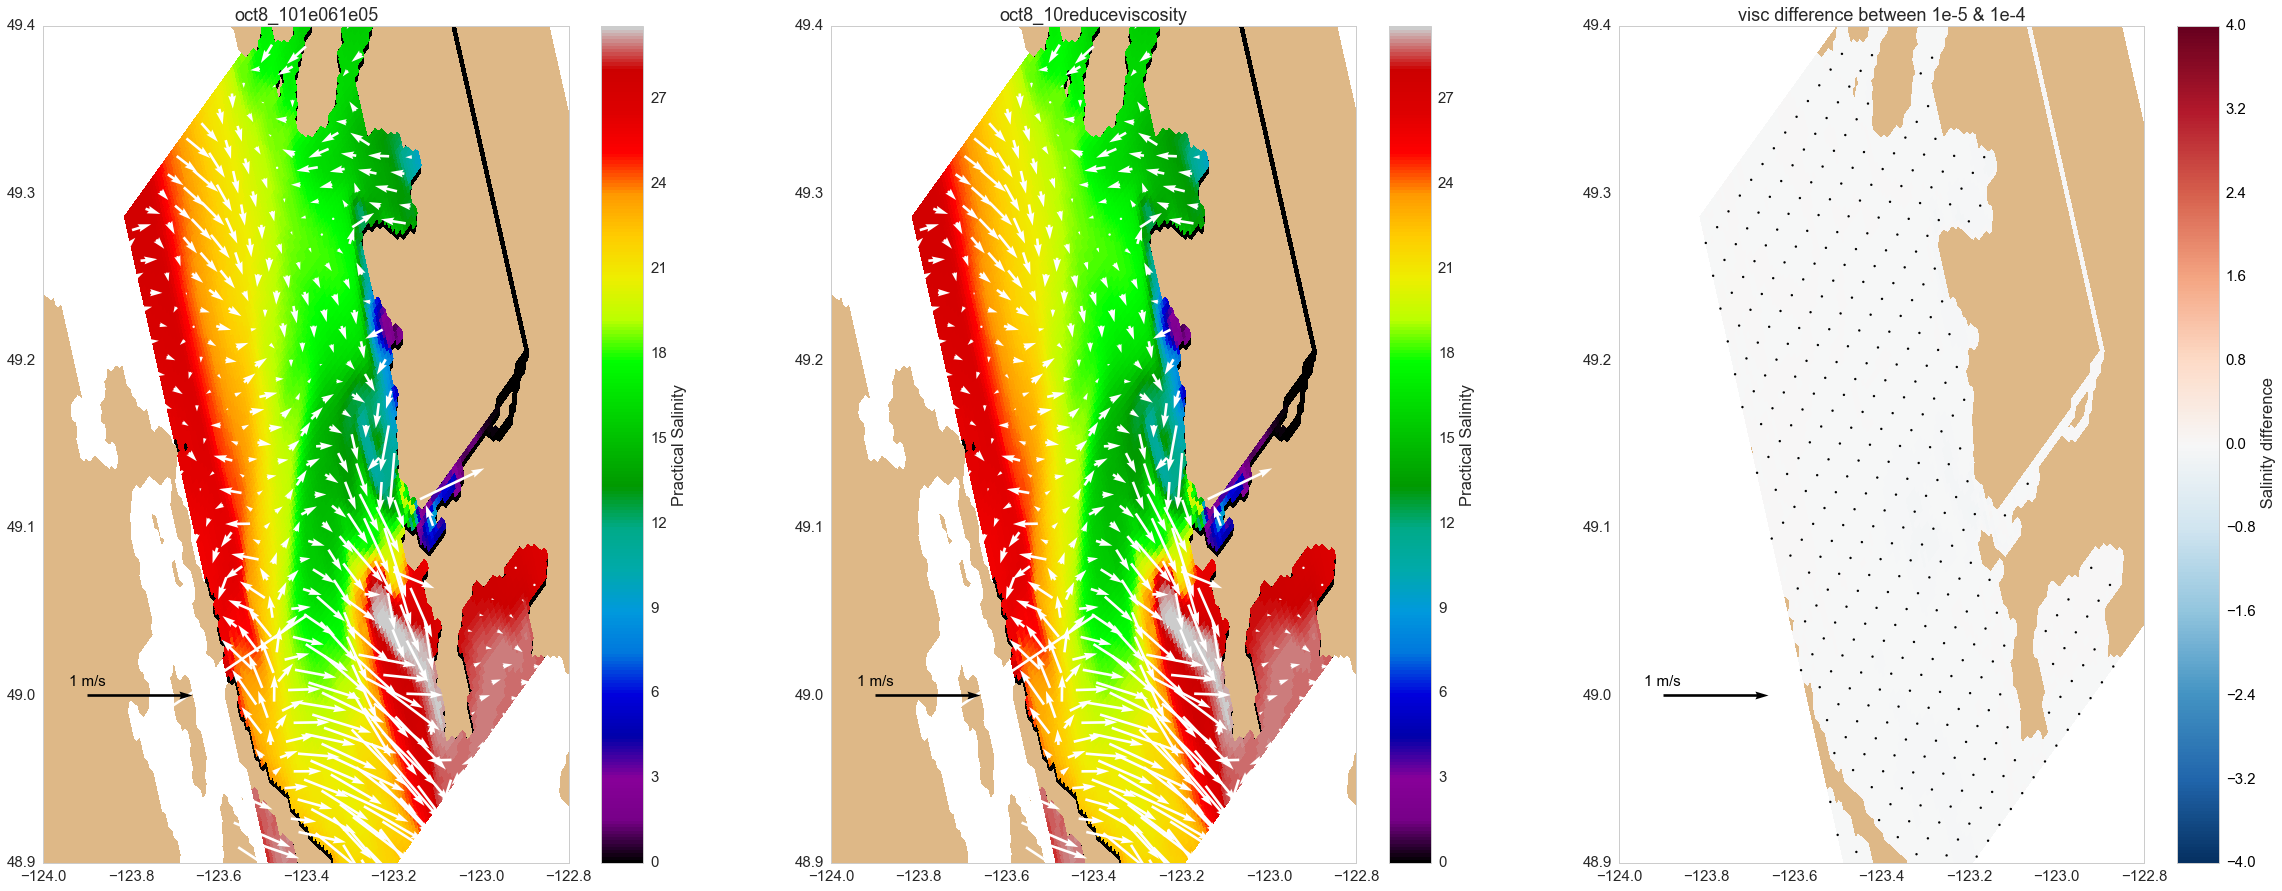

In [5]:
t=0; dep=0
quiver_salinity(t,dep)

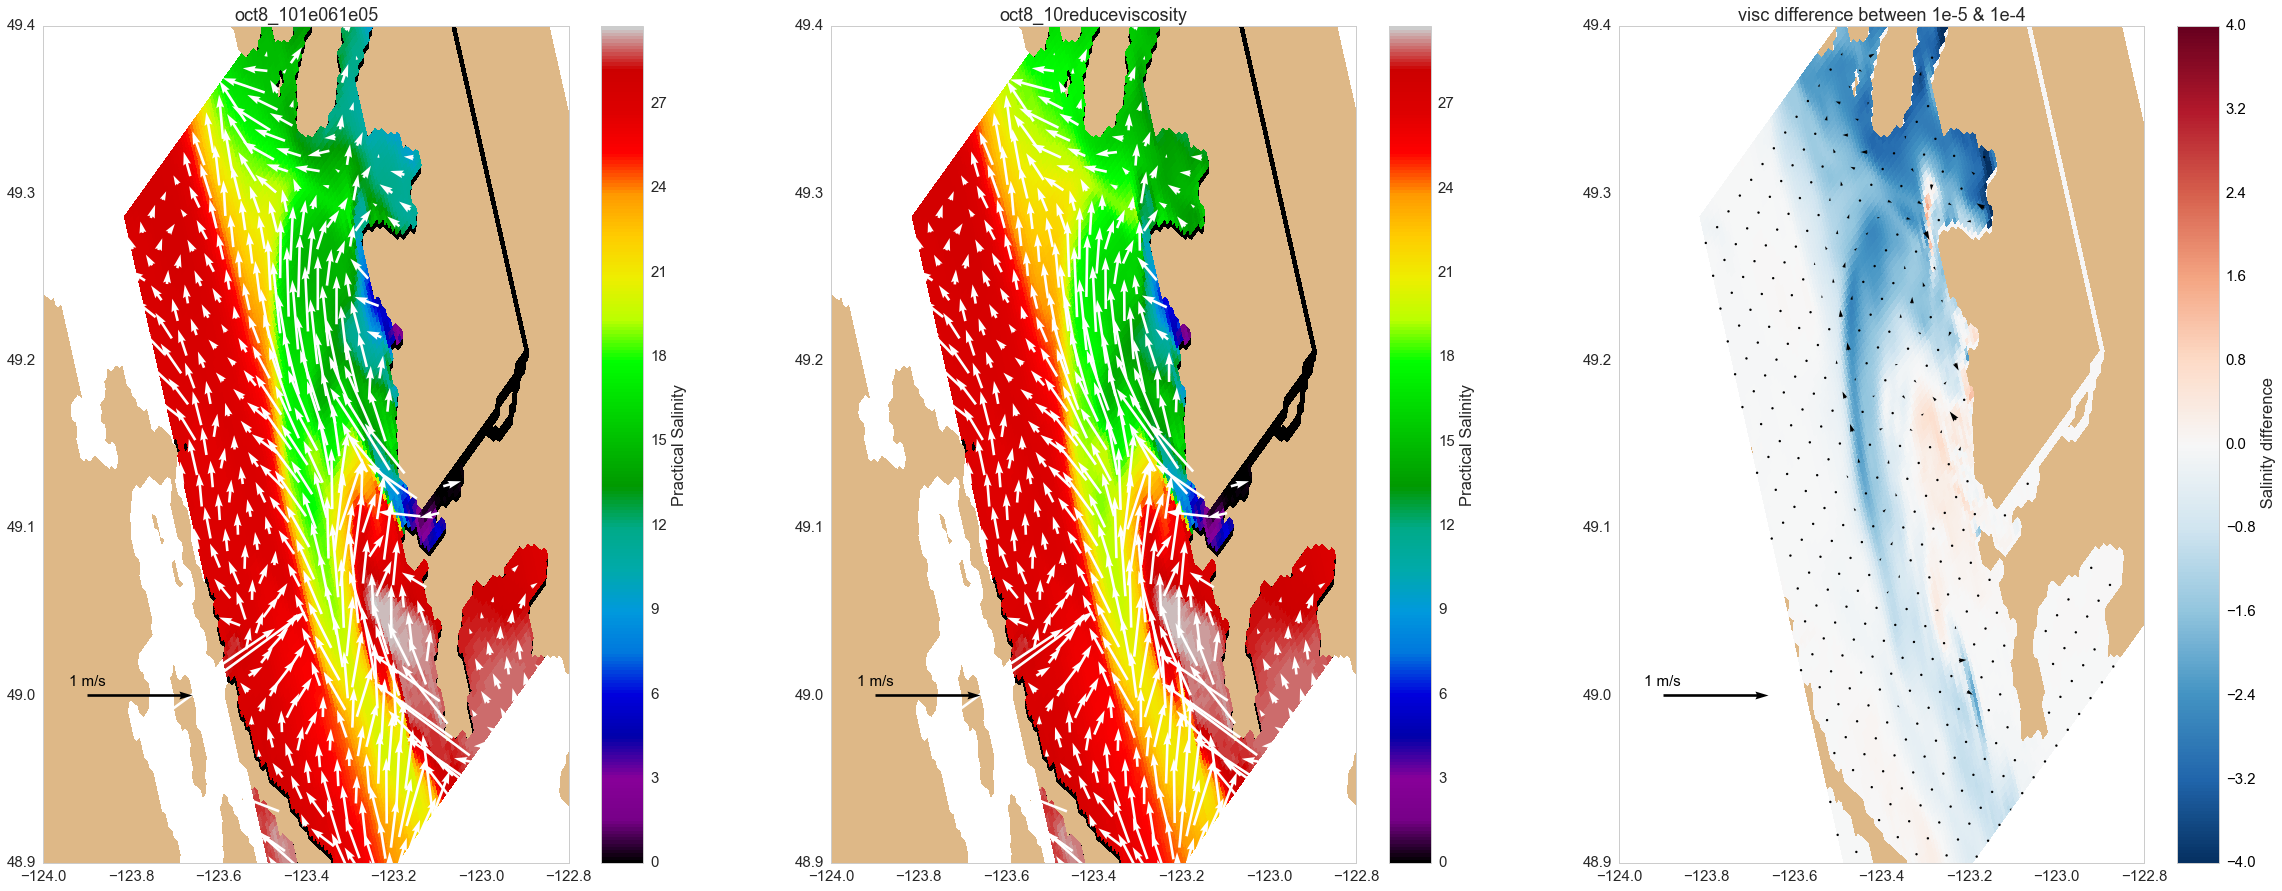

In [6]:
t=71; dep=0
quiver_salinity(t,dep)

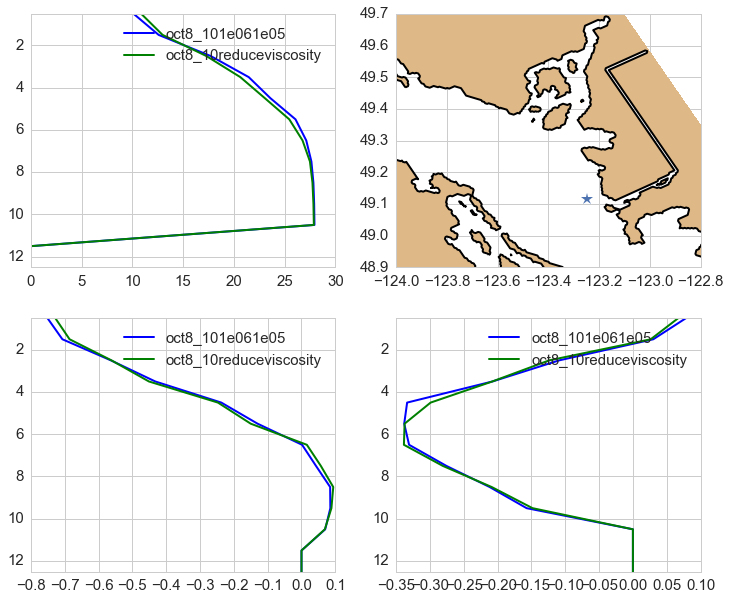

In [7]:
check_SUV_profile(sals,Us,Vs,53,426,302)

* Effects of viscosity

In [8]:
runs=['oct8_10reduceviscosity','oct8_10RFdailySmoo']
base='/data/jieliu/MEOPAR/river-treatment/'
sals={}; depths={}; Us={}; Vs={};SSHs = {}
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
bathy=grid.variables['Bathymetry']
for run in runs:
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_T.nc'.format(run))
    f = nc.Dataset(path,'r');
    sals[run]=f.variables['vosaline']
    depths[run] = f.variables['deptht'] 
    T_lat = f.variables['nav_lat']
    T_lon = f.variables['nav_lon']
    SSHs[run] = f.variables['sossheig']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_U.nc'.format(run))
    f = nc.Dataset(path,'r');
    Us[run]=f.variables['vozocrtx']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_V.nc'.format(run))
    f = nc.Dataset(path,'r');
    Vs[run]=f.variables['vomecrty']

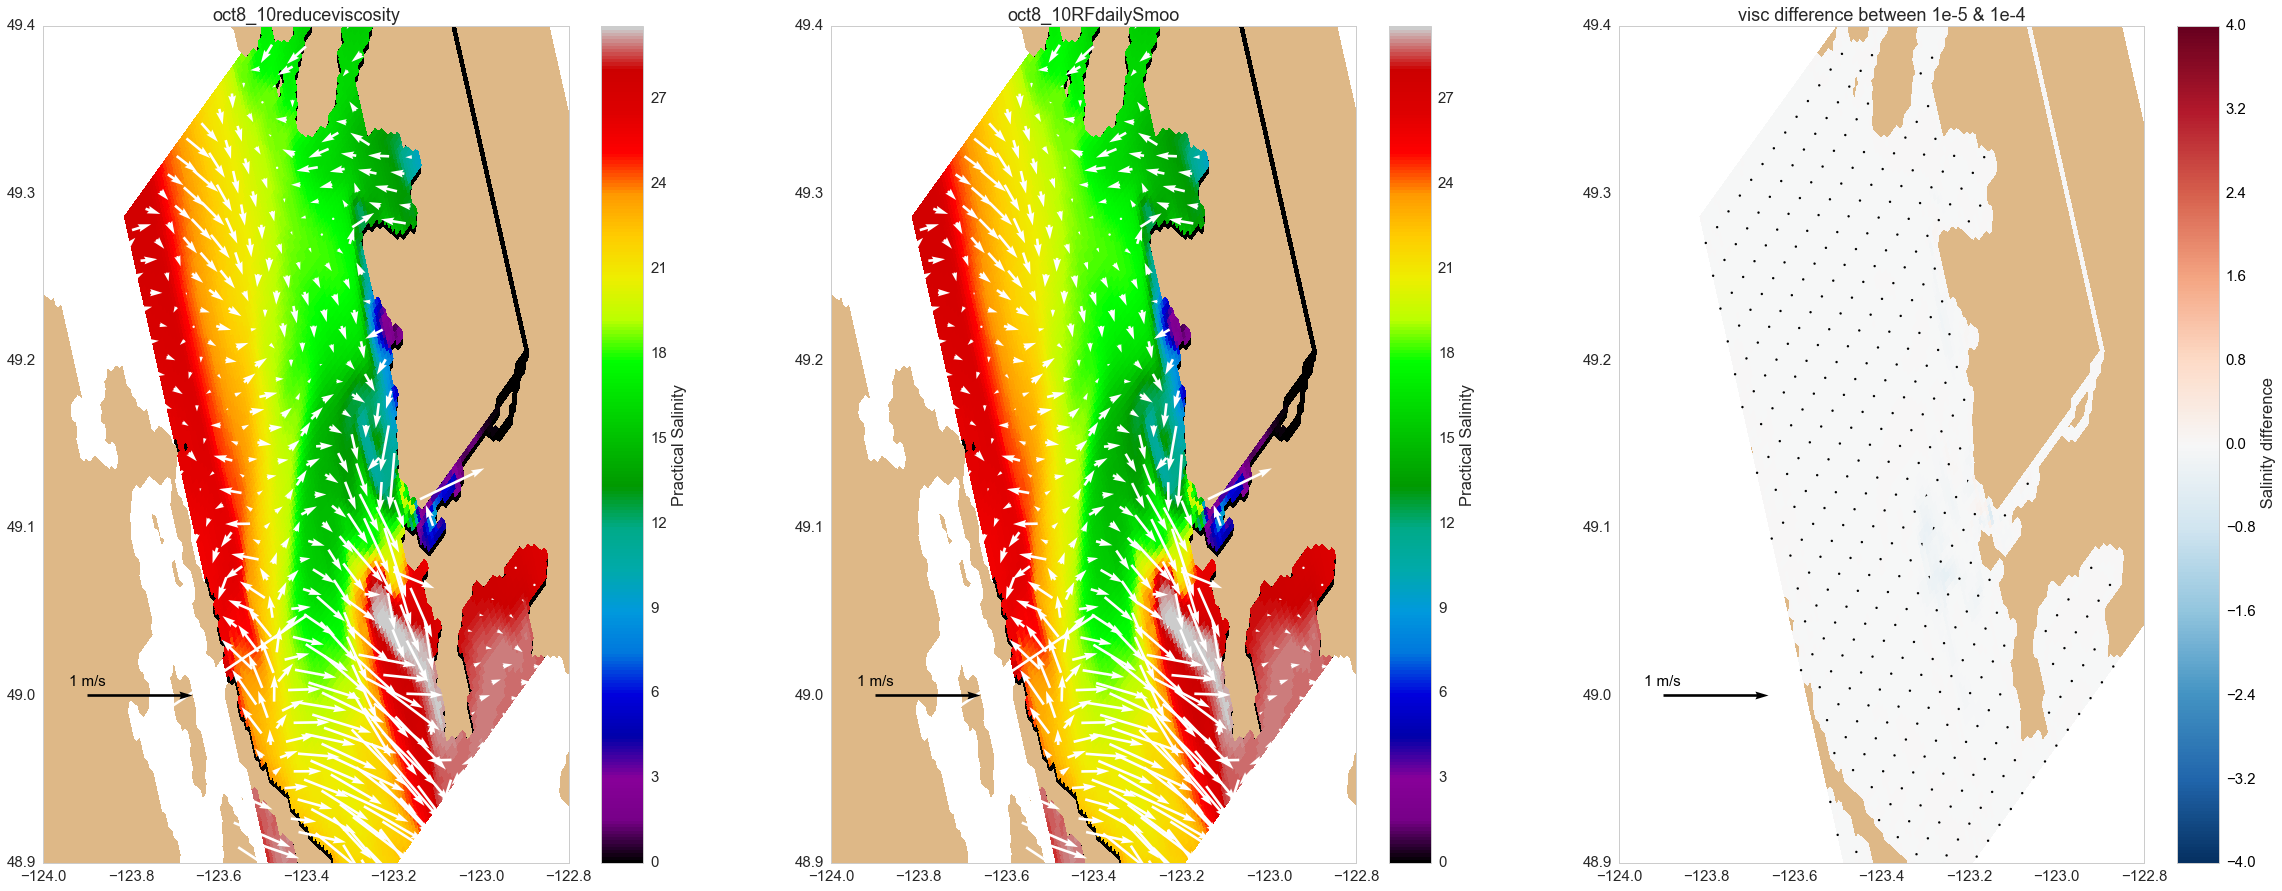

In [9]:
t=0; dep=0
quiver_salinity(t,dep)

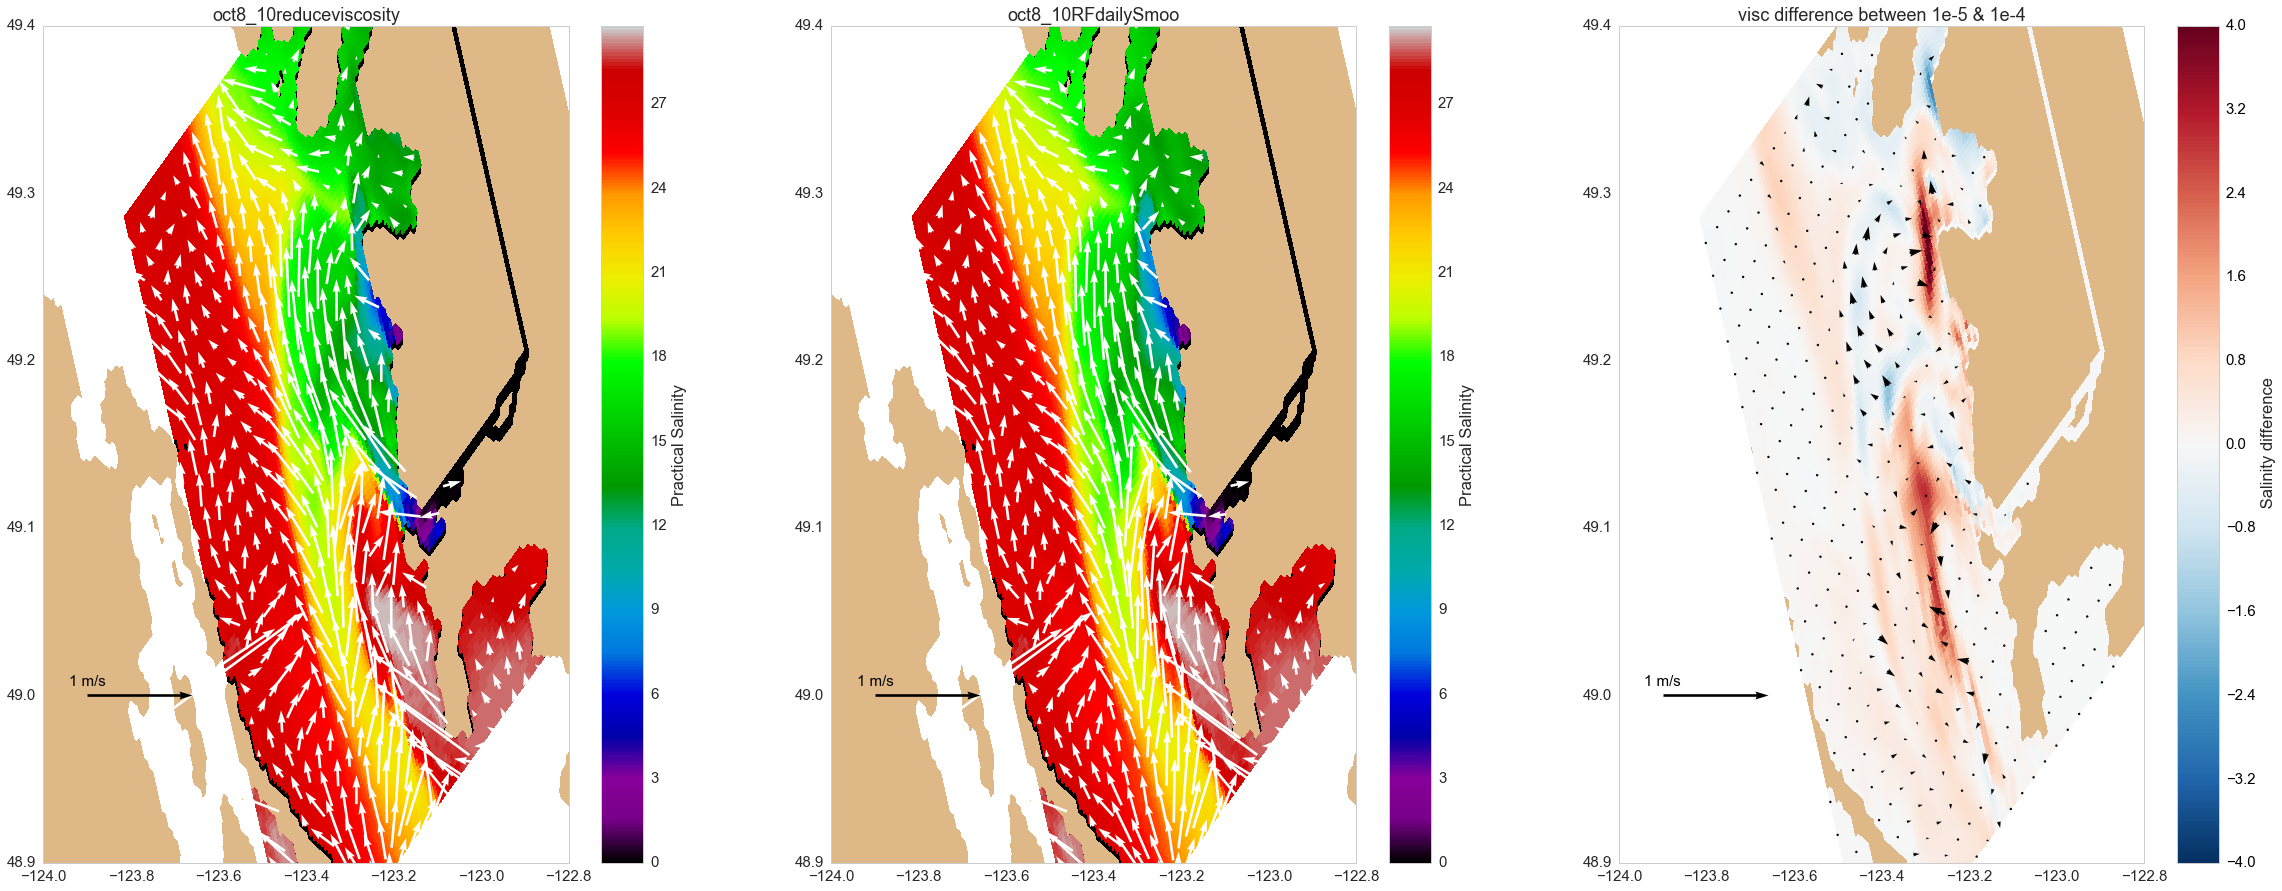

In [10]:
t=71; dep=0
quiver_salinity(t,dep)

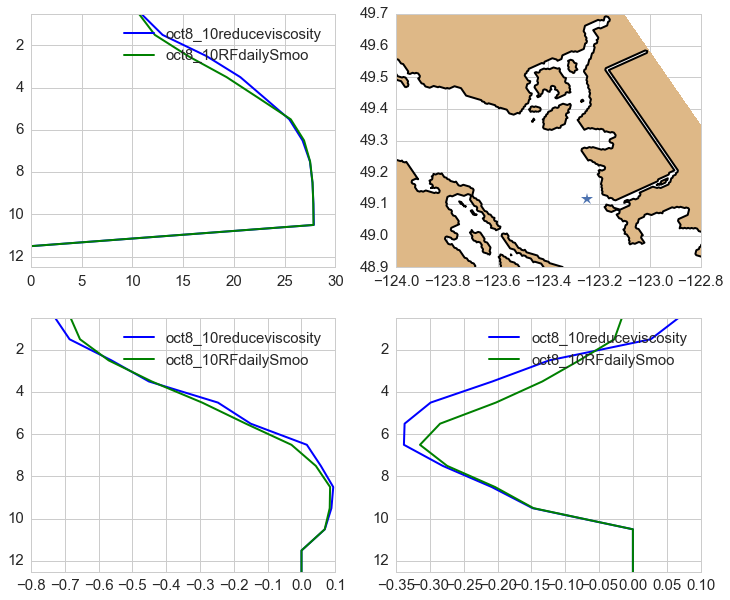

In [11]:
check_SUV_profile(sals,Us,Vs,53,426,302)